Try to tune results obtained to make sure they handle 6 trajectories

In [1]:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** k3 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0, 0  # first set of odes
])

#Define the simulator!
def solve_ode(params, t):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

num_timesteps = 1000  # Number of time steps for simulation
t = np.linspace(0, 100, num_timesteps) #Range of time of simulation
true_data = solve_ode(true_params, t) #True trajectories

# epsilon = 150 NOT NEEDED Error threshold used in kernel, higher than 2 params
# num_samples = 10000 NOT NEEDED # Number of samples to draw

In [2]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer


In [3]:
#better way
num_dim = 3
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
batch_size = 1
num_trajectories = 6

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    batch_size = 1
    solution_tensor = torch.tensor(solution)
    solution_tensor_reshaped = solution_tensor.unsqueeze(0).expand(batch_size, -1, -1)
    return solution_tensor_reshaped


In [4]:
posterior = infer(simulator, prior, method="SNPE", num_simulations=2000)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

Neural network successfully converged after 87 epochs.


In [5]:

# Add a batch dimension to the observation - NOT NEEDED BECAUSE SIMULATIONS ACTUALLY ARE 1x6000 DIMENSIONS
#batch_size = 1
#observation = torch.tensor(true_data)
#true_tensor = observation.unsqueeze(0).expand(batch_size, -1, -1)
#true_tensor

In [8]:
true_merged = []
for i in range(len(true_data)):
    for j in range(6):
        true_merged.append(true_data[i][j])
true_merged
true_merged_tensor = torch.tensor(true_merged)
true_merged_tensor

tensor([ 0.0000,  1.0000,  0.0000,  ..., 32.8362,  1.2295,  2.4615],
       dtype=torch.float64)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

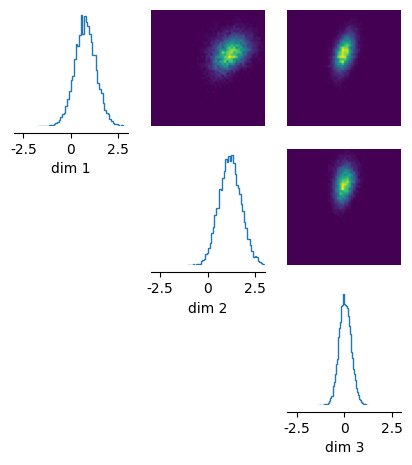

In [9]:
posterior_samples = posterior.sample((10000,), x=true_merged_tensor)
# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-3, 3], [-3, 3], [-3, 3]], figsize=(5, 5)
)